In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from control.modules.thrusters import (
    ThrustersControl,
    ThrustersParameters,
    ThrustersAlarms,
)
from input_output.base import Stamped, StampedDf
from input_output.definitions.simulation import (
    Boundary,
    Pcs,
    TemperatureBoundary,
    Thruster,
)
from input_output.modules.thrusters import (
    ThrustersControlValues,
    ThrustersSensorValues,
    ThrustersSimulationInputs,
    ThrustersSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
import polars as pl
from simulation.models.fmu_paths import thrusters_path


start_time = datetime.fromtimestamp(0)

minutes_idle = 2
minutes_till_high_temp = 23
minutes_after_high_temp = 15

duration = timedelta(
    minutes=minutes_idle + minutes_till_high_temp + minutes_after_high_temp - 1
)


time_index = pl.datetime_range(
    start_time,
    start_time + duration,
    interval="1m",
    time_unit="us",
    eager=True,
)


supply_temperature = StampedDf.stamp(
    pl.DataFrame({
        "time": time_index,
        "value": (minutes_idle + minutes_till_high_temp) * [50.0]
        + minutes_after_high_temp * [80.0],
    })
)
fwd_thruster_active = StampedDf.stamp(
    pl.DataFrame({
        "time": time_index,
        "value": minutes_idle * ["False"]
        + (minutes_till_high_temp + minutes_after_high_temp) * ["True"],
    })
)
fwd_thruster_heat = StampedDf.stamp(
    pl.DataFrame({
        "time": time_index,
        "value": minutes_idle * [0.0]
        + (minutes_till_high_temp + minutes_after_high_temp) * [4300.0],
    })
)

aft_thruster_active = StampedDf.stamp(
    pl.DataFrame({
        "time": time_index,
        "value": minutes_idle * ["False"]
        + (minutes_till_high_temp + minutes_after_high_temp) * ["True"],
    })
)
aft_thruster_heat = StampedDf.stamp(
    pl.DataFrame({
        "time": time_index,
        "value": minutes_idle * [0.0]
        + (minutes_till_high_temp + minutes_after_high_temp) * [9000.0],
    })
)

thrusters_pcs = StampedDf.stamp(
    pl.DataFrame(
        {
            "time": time_index,
            "value": minutes_idle * ["off"]
            + (minutes_till_high_temp + minutes_after_high_temp) * ["propulsion"],
        },
    )
)


simulation_inputs = ThrustersSimulationInputs(
    thrusters_aft=Thruster(heat_flow=aft_thruster_heat, active=aft_thruster_active),
    thrusters_fwd=Thruster(heat_flow=fwd_thruster_heat, active=fwd_thruster_active),
    thrusters_seawater_supply=Boundary(
        temperature=Stamped.stamp(32.0), flow=Stamped.stamp(20.0)
    ),
    thrusters_module_supply=TemperatureBoundary(temperature=supply_temperature),
    thrusters_pcs=Pcs(mode=thrusters_pcs),
)

control = ThrustersControl(
    ThrustersParameters(
        cooling_mix_setpoint=40,
        recovery_thruster_flow=10,
        cooling_thruster_flow=20,
        max_inlet_temp=70,
        recovery_mix_setpoint=60,
    )
)

thrusters_model = SimulatorModel(
    fmu_path=thrusters_path,
    sensor_values_cls=ThrustersSensorValues,
    control_values_cls=ThrustersControlValues,
    simulation_outputs_cls=ThrustersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=ThrustersAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

with thrusters_model.executor() as executor:
    simulation = Simulator(thrusters_model, executor)
    result = await simulation.run(int(duration.total_seconds()))


/Users/alje/Repos/zero/zero-thrs-control/src/orchestration/collector.py:25: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  self._data.vstack(pl.DataFrame({**values, 'time': time, 'control_mode': control_mode}, schema_overrides = self._schema, strict = False), in_place=True)
/Users/alje/Repos/zero/zero-thrs-control/src/orchestration/cycler.py:27: UserWarning: Alarms detected: [Alarm(code='A004', severity=<Severity.ALARM: 'alarm'>)]
  warnings.warn(f"Alarms detected: {alarms}") #TODO: properly handle alarms


In [3]:
import seaborn as sns
palette = sns.color_palette("husl", 11)


variable_names = {
    "thrusters_pump_1__dutypoint__ratio": "pump",
    "thrusters_mix_aft__setpoint__ratio": "mix aft",
    "thrusters_mix_fwd__setpoint__ratio": "mix fwd",
    "thrusters_shutoff_recovery__setpoint__ratio": "shutoff recovery",
    "thrusters_switch_aft__setpoint__ratio": "switch aft",
    "thrusters_switch_fwd__setpoint__ratio": "switch fwd",
    "thrusters_mix_exchanger__setpoint__ratio": "mix exchanger",
    "thrusters_flowcontrol_aft__setpoint__ratio": "flowcontrol aft",
    "thrusters_flowcontrol_fwd__setpoint__ratio": "flowcontrol fwd",
    "thrusters_mix_aft__position_rel__ratio": "mix aft",
    "thrusters_mix_fwd__position_rel__ratio": "mix fwd",
    "thrusters_mix_exchanger__position_rel__ratio": "mix exchanger",
    "thrusters_flowcontrol_aft__position_rel__ratio": "flowcontrol aft",
    "thrusters_flowcontrol_fwd__position_rel__ratio": "flowcontrol fwd",
    "thrusters_shutoff_recovery__position_rel__ratio": "shutoff recovery",
    "thrusters_switch_aft__position_rel__ratio": "switch aft",
    "thrusters_switch_fwd__position_rel__ratio": "switch fwd",
    "thrusters_module_return__temperature__C": "module return",
    "thrusters_temperature_aft_mix__temperature__C": "mix aft",
    "thrusters_temperature_fwd_mix__temperature__C": "mix fwd",
    "thrusters_temperature_supply__temperature__C": "thrusters supply",
    "thrusters_temperature_aft_return__temperature__C": "thruster aft",
    "thrusters_temperature_fwd_return__temperature__C": "thruster fwd",
    "thrusters_seawater_return__temperature__C": "seawater return",
    "thrusters_module_supply__temperature__C": "module supply",
    "thrusters_module_return__flow__l_min": "module return",
    "thrusters_module_supply__flow__l_min": "module supply",
    "thrusters_flow_aft__flow__l_min": "thruster aft",
    "thrusters_flow_fwd__flow__l_min": "thruster fwd",
    "thrusters_flow_recovery_aft__flow__l_min": "recovery aft",
    "thrusters_flow_recovery_fwd__flow__l_min": "recovery fwd",
}

name_styles = {
    "pump": (palette[0], "-"),
    "mix aft": (palette[1], "-"),
    "mix fwd": (palette[1], "--"),
    "mix exchanger": (palette[10], "-"),
    "flowcontrol aft": (palette[2], "-"),
    "flowcontrol fwd": (palette[2], "--"),
    "shutoff recovery": (palette[3], "-"),
    "switch aft": (palette[4], "-"),
    "switch fwd": (palette[4], "--"),
    "module return": (palette[5], '--'),
    "module supply": (palette[5], '-'),
    "thrusters supply": (palette[6], '-'),
    "thruster aft": (palette[7], '-'),
    "thruster fwd": (palette[7], '--'),
    "seawater return": (palette[8], '--'),
    "seawater supply": (palette[8], '-'),
    "recovery aft": (palette[9],'-'),
    "recovery fwd": (palette[9],'--'),
}

control_palette = sns.color_palette("pastel", 3)
control_mode_styles = {"idle": control_palette[0], "recovery": control_palette[1], "cooling": control_palette[2]}

valve_keys = [col for col in variable_names if "__position_rel__" in col]
flow_keys = [col for col in variable_names if "__flow__" in col]
temperature_keys = [col for col in variable_names if "__temperature__" in col]
control_keys = [col for col in variable_names if ("__dutypoint__" in col or "__setpoint__" in col)]


selected_keys = [(control_keys,"Control values [ratio]"), (valve_keys, "Valve position [ratio]"), (temperature_keys,"Temperature [°C]"), (flow_keys,"Flow [l/min]")]


(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='time', ylabel='Control values [ratio]'>,
        <Axes: xlabel='time', ylabel='Valve position [ratio]'>],
       dtype=object))

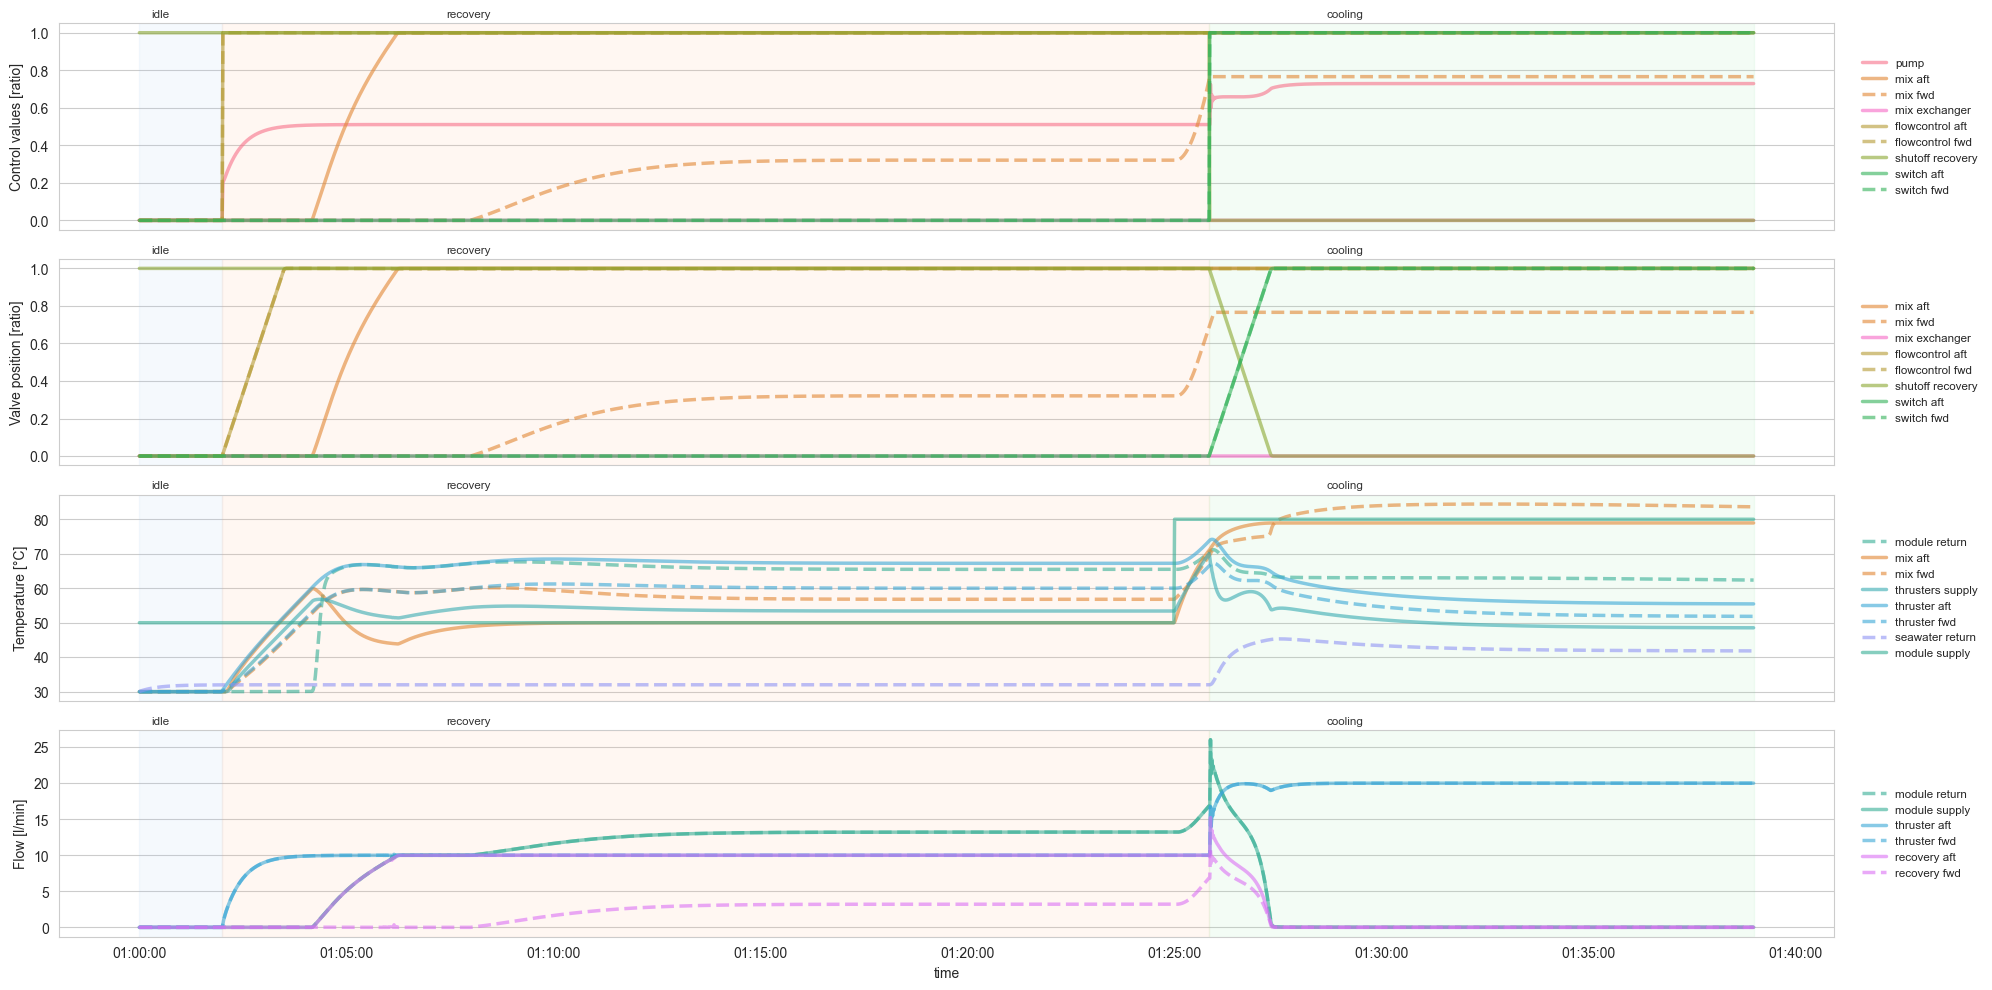

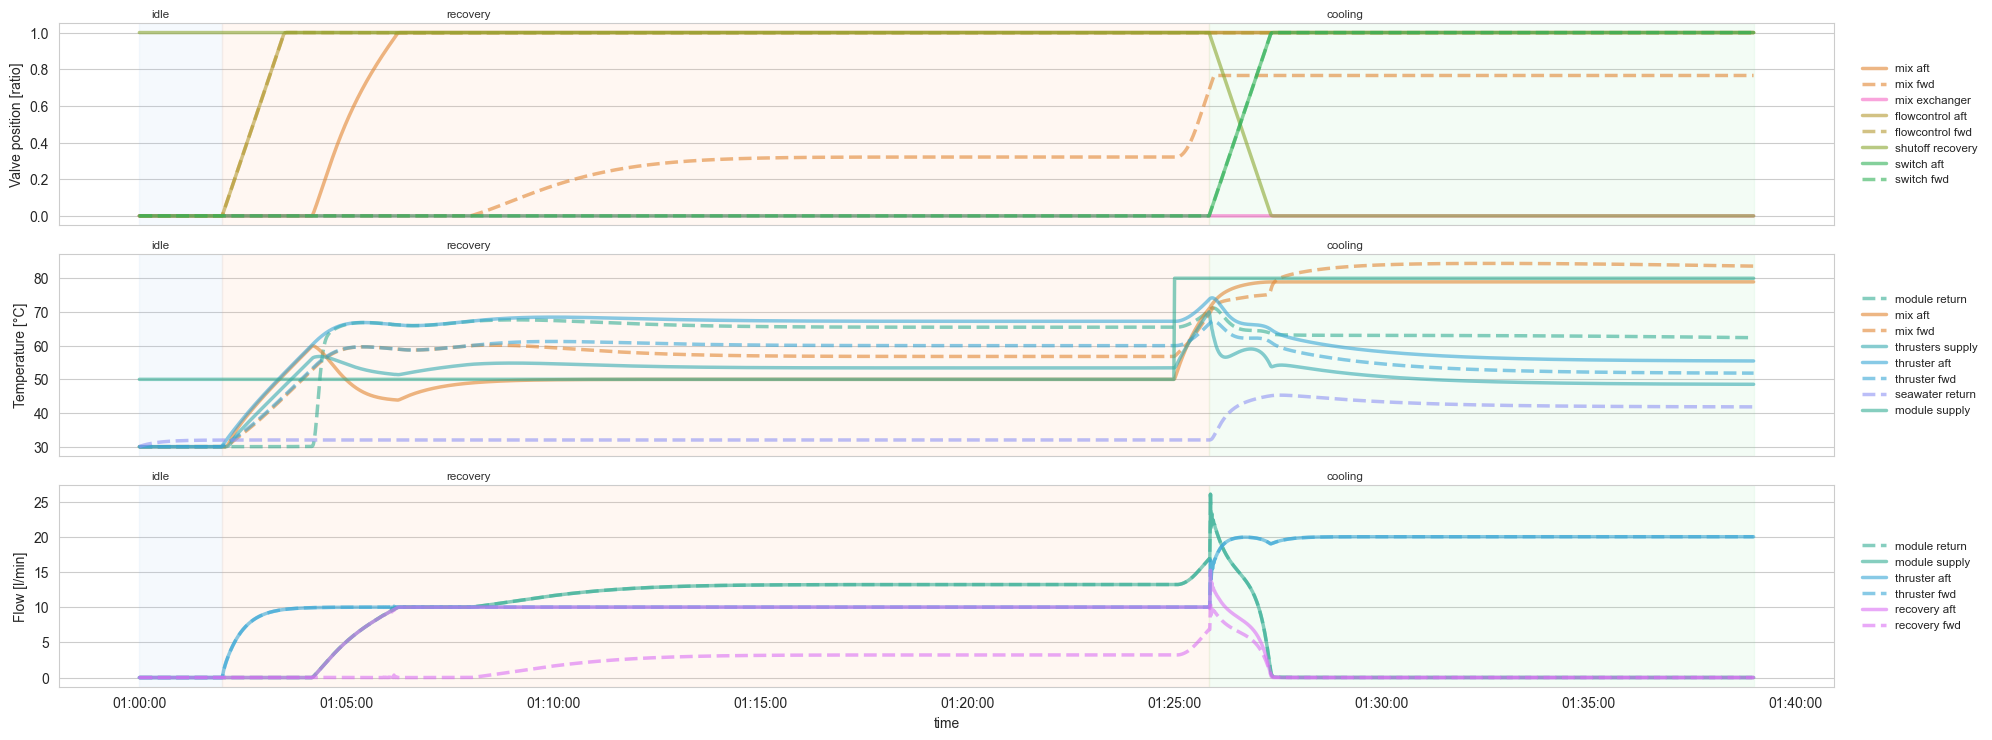

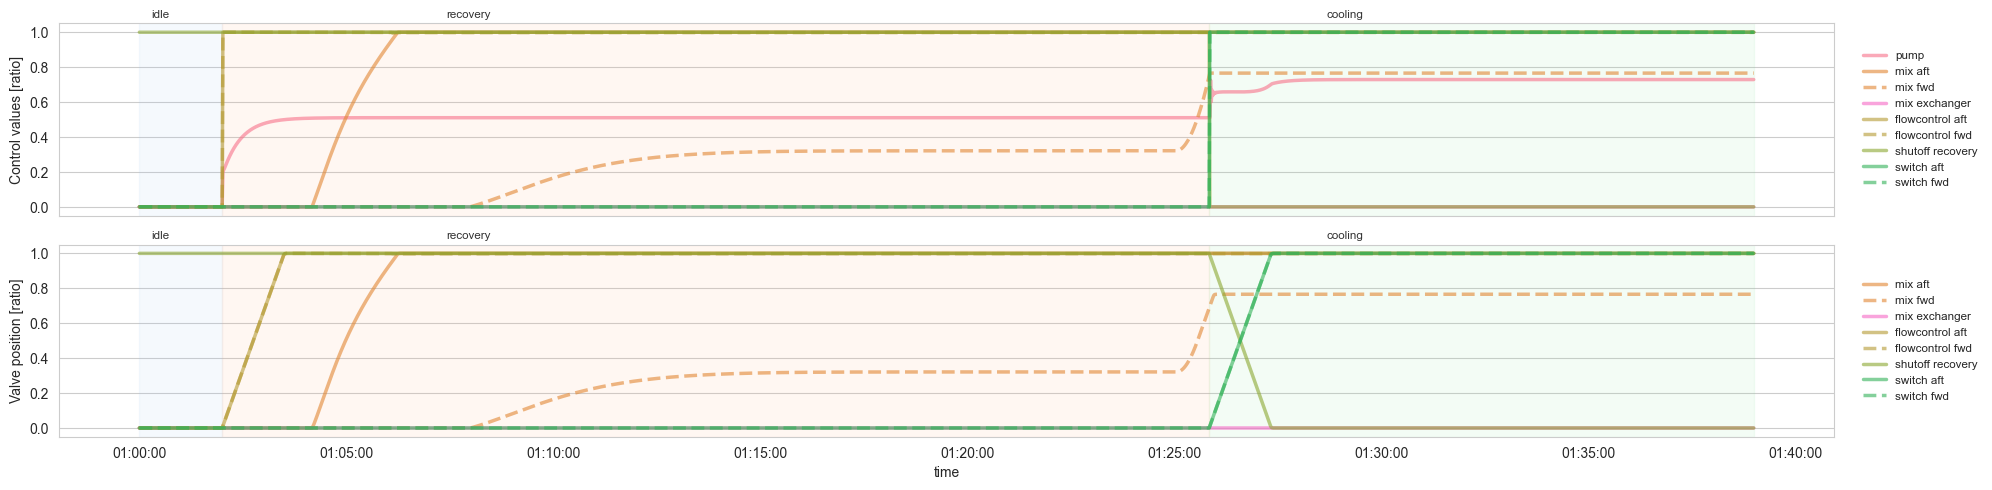

In [4]:
from analysis.analysis_utils import plot_result_by_variables

# recovery_df = result.filter(pl.col("time") < datetime.fromtimestamp(60 * 60))
# modes_df = result.filter(pl.col("time") >= datetime.fromtimestamp(50 * 60))

plot_result_by_variables(result, variable_names, name_styles, control_mode_styles, selected_keys, "plots/paper_plot_full.png", figure_width = 20)
#plot_result_by_variables(recovery_df, variable_names, name_styles, control_mode_styles, "plots/paper_plot_recovery.png")
#plot_result_by_variables(modes_df, variable_names, name_styles, control_mode_styles, "plots/paper_plot_modes.png");

plot_result_by_variables(
    result,
    variable_names,
    name_styles,
    control_mode_styles,
    [
        (valve_keys, "Valve position [ratio]"),
        (temperature_keys, "Temperature [°C]"),
        (flow_keys, "Flow [l/min]"),
    ],
    "plots/paper_plot_ex_signal.png",
    figure_width=20,
)
plot_result_by_variables(
    result,
    variable_names,
    name_styles,
    control_mode_styles,
    [
        (control_keys, "Control values [ratio]"),
        (valve_keys, "Valve position [ratio]"),
    ],
    "plots/paper_plot_signal_vs_actuator.png",
    figure_width=20,
)